
# Tweaking the (non-) linear solvers
Here we look at how to tweak the internal linear and nonlinear solvers.
The `solve` method on the `schemes` uses a Newton method to solve
the (non)linear PDE model. Parameters set during the construction of a `scheme`
can be used to customize the Newton solver and the underlying solver for
the linear problem in each step, i.e., setting line-search parameters or
preconditioners. A number of linear solvers and some simple
preconditioners are directly available and others can be used through
additional software packages. This is done by changing the
linear algebra backend (e.g. using `petsc`) by using the
`storage` parameter during construction of the discrete space.
The simplicity of the default backend (`numpy`) allows to extract the
underlying data structures to use with Numpy/Scipy on the python side.
A degrees of freedom vector (dof vector) can be retrieved as `numpy.array`
from a discrete function with this default storage by using the `as_numpy`
attribute on an instance of a discrete function. Similar attributes are available
for the other storages, i.e., `as_istl,as_petsc`. The same attributes are
also available to retrieve the underlying matrix structures on linear
operators/schemes.
A short description on the other storages with examples using the internal
bindings for these packages follows at the end of this section.
We will discuss how to use these attributes to implement (parts of)
the solution algorithm on the Python side using `Scipy` or `PETSc4py`
[will follow](solversExternal_nb.ipynb).

We will mostly revisit the nonlinear problem studied at the end of the
section on [non-linear elliptic problems](dune-fempy_nb.ipynb#A-non-linear-elliptic-problem)
in the introduction - using a prescribed forcing to obtain the exact solution
\begin{align*}
u(x,y) = \left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}
The following code was described in the [introduction](dune-fempy_nb.ipynb)

In [1]:
import numpy

from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange
from dune.fem import integrate
from ufl import TestFunction, TrialFunction, SpatialCoordinate, FacetNormal, \
                dx, ds, div, grad, dot, inner, exp, sin, conditional

gridView = leafGridView([0, 0], [1, 1], [24, 24])
space = lagrange(gridView, order=2)
u_h = space.interpolate(0, name='u_h')

x,u,v,n = ( SpatialCoordinate(space), TrialFunction(space), TestFunction(space), FacetNormal(space) )
exact = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1

a  = ( inner(grad(u),grad(v)) + (1+u)**2*u*v ) * dx
bf = (-div(grad(exact)) + (1+exact)**2*exact) * v * dx
bg = dot(grad(exact),n)*v*ds

# simple function to show the result of a simulation
def printResult(method,error,info):
    print(method,"L^2, H^1 error:",'{:0.5e}, {:0.5e}'.format(
                 *[ numpy.sqrt(e) for e in integrate([error**2,inner(grad(error),grad(error))]) ]),
          "\n\t","solver info=",info,flush=True)

When creating a scheme, it is possible to set the linear solver as well as
parameters for the internal Newton solver and the linear solver (e.g. for
preconditioning). See a list of available solvers and preconditioning
methods at [the end of this section](#Available-solvers-and-parameters).
The default solver is a `gmres`
method but since this problem is symmetric a `cg` solver is more
efficient. In addition we will use a Jacobi preconditioner and set
the tolerance for the Newton method to $10^{-8}$. In addition we also
use the `Eisenstat-Walker` strategy for choosing the tolerance for the
linear solver - this requires the error measure to be `residual
reduction`.

In [2]:
from dune.fem.scheme import galerkin
scheme = galerkin(a == bf+bg, solver='cg',
                  parameters={"linear.preconditioning.method":"jacobi",
                              "nonlinear.forcing":"eisenstatwalker",
                              # this is the default for this forcing
                              "linear.errormeasure":"residualreduction",
                              "nonlinear.tolerance":1e-7},
                 )

.. tip:: we use Krylov methods like `cg` and `gmres` in this section to
   solve the linear problems. We also provide bindings for direct solvers
   from the `suitesparse` package, e.g., `umfpack` if installed. For this use
   `solver=["suitesparse","umfpack"]` when constructing the scheme.

We can simply use the `galerkin` scheme instance to compute the solution
as shown previously in [the introduction section](dune-fempy_nb.ipynb).

Default L^2, H^1 error: 1.17598e-06, 1.83002e-04 
	 solver info= {'converged': True, 'iterations': 5, 'linear_iterations': 289, 'timing': [0.077352758, 0.023532723, 0.053820034999999995]}


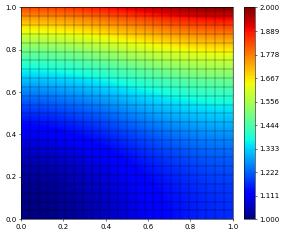

In [3]:
u_h.interpolate(2)               # start with the boundary conditions at the top
info = scheme.solve(target=u_h)
printResult("Default",u_h-exact,info)
u_h.plot()


## Python sided Newton solver
We can also only use the internal linear solvers and write the Newton
method in Python - here is a very simple version of that.
The central new method is `linear` available on the scheme that returns a
linear `scheme` which represents the Jacobian of the model around a given grid function `ubar`.
Much more details on the methods used are given
[in the next section](solversExternal_nb.ipynb).

In [4]:
class Scheme1:
    def __init__(self, scheme, u0):
        self.scheme = scheme
        self.jacobian = scheme.linear(ubar=u0) # obtain a linear operator for the Newton method

    def solve(self, target):
        # create a copy of target for the residual
        res = target.copy(name="residual")
        dh  = target.copy(name="direction")
        n, linIter = 0,0
        while True:
            # res = S[u]
            #     = u - g on boundary
            self.scheme(target, res)
            absF = res.scalarProductDofs(res)
            if absF < 1e-7**2: # this is the same tolerance we set above for the built-in Newton solver
                break
            self.scheme.jacobian(target,self.jacobian)  # assemble the linearization
            # dh = DS[u]^{-1}S[u]
            #    = u - g on boundary
            dh.clear()
            info = self.jacobian.solve(target=dh,rightHandSide=res)
            linIter += info["linear_iterations"]
            # unew = u - DS[u]^{-1}S[u]
            #      = u - (u-g) = g on boundary
            target -= dh
            n += 1
        return {"iterations":n, "linear_iterations":linIter}

u_h.interpolate(2)                        # start with the boundary conditions at the top
scheme_cls = Scheme1(scheme,u0=u_h)
info = scheme_cls.solve(target=u_h)
printResult("Newton 1",u_h-exact,info)

Newton 1 L^2, H^1 error: 1.17597e-06, 1.83002e-04 
	 solver info= {'iterations': 4, 'linear_iterations': 619}


.. tip:: The iterative linear solvers use the provided target discrete
   function as initial guess for the iteration - so here we are starting
   with `0` in each step of the Newton method.

A second version using a linearization of the non-linear problem
including an affine shift, i.e., the first two terms in the Taylor
expansion around a given $\bar{u}$:
$$ L[u] = DS[\bar{u}](u-\bar{u}) + S[\bar{u}] $$

In [5]:
from dune.fem.scheme import linearized
class Scheme2:
    def __init__(self, scheme, u0):
        self.scheme = scheme
        # let's use a `gmres` solver for demonstration purposes
        self.linear = linearized(scheme, ubar=u0,
                      parameters={ "method":"gmres", "gmres.restart":50,
                               # the scheme uses Eisenstat-Walker forcing
                               # with 'residual reduction' as error measure
                               # without the forcing 'absolute' is the default error measure
                               "errormeasure":"absolute",
                            })

    def solve(self, target):
        prev = target.copy()
        n, linIter = 0,0
        # we are not computing the residual directly so need a different
        # stopping criteria, i.e., size of the step dh
        while True:
            # setup L[u] = DS[u^n](u-u^n) + S[u^n]
            # Then L[u] = 0 leads to
            # u = (DS[u^n])^{-1} (DS[u^n]u^n-S[u^n])
            #   = u^n - DS[u^n])^{-1}S[u^n]
            #   = u^{n+1}
            self.linear.setup(target)
            info = self.linear.solve(target=target)
            linIter += info["linear_iterations"]

            # We don't have access to the residual so we use |u^{n+1}-u^n|
            # as stopping criteria.
            # Subtract the new iterate from the previous one
            prev.sub( target )
            absDiff = prev.scalarProductDofs(prev)
            print(n,absDiff)
            if absDiff < 1e-7**2:
                break
            prev.assign(target)
            n += 1
        return {"iterations":n, "linear_iterations":linIter}

u_h.clear()                         # reset u_h - so we start the Newton method with u_h=0
scheme_cls = Scheme2(scheme,u_h)
info = scheme_cls.solve(target=u_h)
printResult("Newton 2 (gmres)",u_h-exact,info)

0 141085.76467817265
1 17905.922126842455
2 7537.485971022514
3 2816.7398167325914
4 729.4502131630727
5 67.95222228769525
6 0.5837225090318674
7 4.080727400222704e-05
8 0.0
Newton 2 (gmres) L^2, H^1 error: 1.17601e-06, 1.83002e-04 
	 solver info= {'iterations': 8, 'linear_iterations': 2076}


.. tip:: the parameters used to tweak the linear solver set when constructing
   the `scheme` are passed on to the linear solver when calling
   `scheme.linear` but can be overwritten.
   Below we construct a linearization (by default around zero) which uses a `gmres`
   method when calling `jac.solve` - the same would work with
   `sc.linear(parameter={..})`.

Here is another example of this:

In [6]:
model = ( inner(grad(u), grad(v)) + (u - conditional(dot(x,x)<0.6,10.,0.))*v ) * dx
# verbose output for the linear solver is too long so use default `False` setting
sc  = galerkin(model==0, solver="cg",
               parameters={"linear.verbose":False,"nonlinear.verbose":True}
              )
sol = space.interpolate(0, name="u_h")
jac = linearized(sc, parameters={ "method":"gmres", "gmres.restart":100, })
info = jac.solve(target=sol)
print(info,flush=True)

{'converged': True, 'iterations': 0, 'linear_iterations': 1106, 'timing': []}


Since we setup the `scheme` using `solver="cg"` calling the `solve`
method will use the Newton method with a `cg` solver - some verbose
output is provided in each step of the Newton method due to
`"nonlinear.verbose":True`:

In [7]:
sol.clear()
info = sc.solve(target=sol)
print(info,flush=True)

{'converged': True, 'iterations': 0, 'linear_iterations': 213, 'timing': [0.025146098, 0.004754108999999999, 0.020391989]}


.. tip:: since the problem is linear the Newton method produces no real overhead.

.. index::
   triple: Solvers; Dirichlet; Conditions

.. index::
   pair: Boundary; Linear Solvers

## Handling Dirichlet boundary conditions
We first look at a simple Poisson problem with Dirichlet BCs
to show how to use the internal solvers in this setting.
We solve $-\triangle u=15\chi_\omega$ where $\chi_\omega$ is a characteristic
function with $\omega=\{x\colon |x|^2<0.6\}$. For the boundary
we prescribe trivial Neumann at the top and bottom boundaries
and Dirichlet values $u=-1$ and $u=1$ at the left and right
boundaries, respectively.

In [8]:
from dune.ufl import DirichletBC
model = ( inner(grad(u), grad(v)) - 15*conditional(dot(x,x)<0.6,1.,0.) * v ) * dx
dbcs  = [ DirichletBC(space,-1,1), DirichletBC(space, 1,2) ]
op  = galerkin([model==0, *dbcs], space)
sol = space.interpolate(0, name="u_h")
lin = op.linear()

So far everything is as before. Dirichlet boundary conditions
are handled in the matrix through changing all rows
associated with boundary degrees of freedom to unit rows -
associated columns are not changed so the matrix will not be symmetric anymore.
For solving the system we need to modify the right hand side
and the initial guess for the iterative solver to include
the boundary values (to counter the missing symmetry).
We can use the first of the three versions of the
`setConstraints` methods on the scheme class discussed in the section on
[more general boundary conditions](boundary_nb.ipynb#Accessing-the-Dirichlet-degrees-of-freedom).

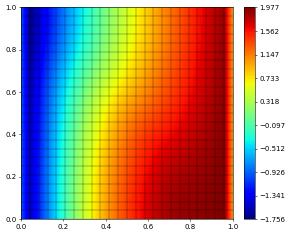

In [9]:
op.setConstraints(sol)

# setup the right hand side
rhs = sol.copy()
op(sol,rhs)
rhs *= -1
op.setConstraints(rhs)
lin.solve(rightHandSide=rhs,target=sol)
sol.plot()

Let's revisit our two implementations of the Newton method discussed
above but with Dirichlet conditions on the whole boundary:

In [10]:
scheme = galerkin([a == bf, DirichletBC(space,exact)], solver='cg')

First version with `scheme.linear`:

In [11]:
u_h.interpolate(2)                        # start with the boundary conditions at the top
scheme_cls = Scheme1(scheme,u0=u_h)
info = scheme_cls.solve(target=u_h)
printResult("Dirichlet, Newton 1",u_h-exact,info)

Dirichlet, Newton 1 L^2, H^1 error: 1.17658e-06, 1.83002e-04 
	 solver info= {'iterations': 4, 'linear_iterations': 414}


and using the `linearized` operator:

In [12]:
u_h.interpolate(2)
scheme_cls = Scheme2(scheme,u0=u_h)
info = scheme_cls.solve(target=u_h)
printResult("Dirichlet, Newton 2",u_h-exact,info)

0 994.7300931673126
1 14.080846388373416
2 0.005556564215679982
3 1.0225993011519528e-09
4 0.0
Dirichlet, Newton 2 L^2, H^1 error: 1.17659e-06, 1.83002e-04 
	 solver info= {'iterations': 4, 'linear_iterations': 518}


## Other internal solvers (petsc)
.. index::
   pair: Solvers; Petsc

The following requires that a PETSc installation was found during the
configuration of ``dune``.

In [13]:
from dune.common.checkconfiguration import assertCMakeHave, ConfigurationError
try:
    assertCMakeHave("HAVE_PETSC")
    petsc = True
except ConfigurationError:
    print("Dune not configured with petsc - skipping example")
    petsc = False

We provide internal bindings to parts of the PETSc package and show this
first. How to make use of `petsc4py` is shown
[in a later section](solversExternal_nb.ipynb).

Switching to a storage based on the PETSc solver package and solving the
system using the dune-fem bindings can be achieved by using the
``storage`` argument to the space constructor.

.. note:: We can use the
   ufl forms we already have defined. Normally the space
   to use is extracted from the form but this can
   be overwritten by providing a `space` argument
   during scheme construction.

We'll use Dirichlet BCs at the left boundary only:

In [14]:
if petsc:
    spacePetsc = lagrange(gridView, order=2, storage='petsc')
    # We use an sor preconditioner:
    schemePetsc = galerkin([a == bf+bg, DirichletBC(space,exact,2)],
                           space=spacePetsc, solver="cg",
                           parameters={"linear.preconditioning.method":"hypre"})
    uPetsc_h = spacePetsc.interpolate(2, name='u_h')
    info = schemePetsc.solve(target=uPetsc_h)
    printResult("PETSc",uPetsc_h-exact,info)

PETSc L^2, H^1 error: 1.17613e-06, 1.83002e-04 
	 solver info= {'converged': True, 'iterations': 4, 'linear_iterations': 22, 'timing': [0.078212362, 0.049349553000000004, 0.02886280899999999]}


## Other internal solvers (istl)
.. index::
   pair: Solvers; dune-istl

We can just as easily use the `dune-istl` package to solve the system
(`dune-istl` should be available when installing `dune-fem`).

.. tip:: instead of changing the storage in the space requiring some
   extra compilation it is also possible to provide the solver
   information directly to the scheme as shown here.

In [15]:
spaceIstl = lagrange(gridView, order=2, storage='istl')
# We use an amg preconditioner:
schemeIstl = galerkin(a == bf+bg, solver=("istl","cg"),
                      parameters={"linear.preconditioning.method":"amg-jacobi"})
u_h.interpolate(2)
info = schemeIstl.solve(target=u_h)
printResult("Dune-Istl",u_h-exact,info)

Dune-Istl L^2, H^1 error: 1.17597e-06, 1.83002e-04 
	 solver info= {'converged': True, 'iterations': 4, 'linear_iterations': 42, 'timing': [0.107077367, 0.020071142, 0.087006225]}


.. index::
   triple: I/O; Logging; Parameters

## Parameters for fine-tuning the internal solvers
Sometimes it is necessary to extract which parameters were read and which
values were used, e.g., for debugging purposes like finding spelling
in the parameters provided to a scheme.
Note that this information can only be reliably obtained after usage of
the scheme, e.g., after calling solve as shown in the example below.
To add logging to a set of parameters passed to a `scheme` one simply
needs to add a `logging` key to the parameter dictionary provided to the scheme
with a tag (string) that is used in the output.

As an example we will solve the simple Laplace equation from the
introduction but pass some preconditioning parameters to the scheme.

In [16]:
import dune.fem
from dune.grid import structuredGrid
from dune.fem.space import lagrange
from ufl import (TestFunction, TrialFunction, SpatialCoordinate,
                 dx, grad, inner, dot, sin, cos, pi )
gridView = structuredGrid([0, 0], [1, 1], [200, 200])
space = lagrange(gridView, order=1)
u_h   = space.interpolate(0, name='u_h')
x = SpatialCoordinate(space)
u = TrialFunction(space)
v = TestFunction(space)

f = (8*pi**2+1) * cos(2*pi*x[0])*cos(2*pi*x[1])
a = ( inner(grad(u),grad(v)) + u*v ) * dx
l = f*v * dx
scheme = galerkin( a==l, solver="cg", parameters=
                   {"linear.tolerance": 1e-12,
                    "linear.verbose": True,
                    "linear.preconditioning.method": "jacobi",
                    "linear.errormeasure": "relative",
                    "logging": "log-jacobi"
                   } )
info = scheme.solve(target=u_h)

Fem::CG preconditioning=jacobi
Fem::CG it: 0 : sqr(residuum) 9.91003e-26
Fem::CG it: 1 : sqr(residuum) 1.1676e-26


We use the `pprint` (pretty print) module if available to get nicer
output.

In [17]:
try:
    from pprint import pprint as _pprint
    pprint = lambda *args,**kwargs: _pprint(*args,**kwargs,width=200,compact=False)
except ImportError:
    pprint = print

pprint(dune.fem.parameter.log())

{'default': {('fem.solver.threading', 'true'), ('fem.dofmanager.clearresizedarrays', 'true'), ('fem.dofmanager.memoryfactor', '1.1'), ('fem.threads.communicationthread', 'false')},
 'log-jacobi': {('fem.solver.linear.maxiterations', '2147483647'),
                ('fem.solver.linear.preconditioning.iterations', '1'),
                ('fem.solver.linear.preconditioning.relaxation', '1.1'),
                ('fem.solver.linear.threading', 'true'),
                ('fem.solver.nonlinear.forcenonlinear', 'false'),
                ('fem.solver.nonlinear.forcing', 'none'),
                ('fem.solver.nonlinear.linesearch', 'none'),
                ('fem.solver.nonlinear.maxiterations', '2147483647'),
                ('fem.solver.nonlinear.maxlinesearchiterations', '2147483647'),
                ('fem.solver.nonlinear.simplified', 'false'),
                ('fem.solver.nonlinear.tolerance', '1e-06'),
                ('fem.solver.nonlinear.verbose', 'false'),
                ('linear.errormeas

Note above that all parameters are printed including some default ones
used in other parts of the code. If multiple schemes with different
`logging` parameter strings are used, all would be shown using the `log`
method as shown above.
To access only the parameters used in the scheme simply use
either `dune.fem.parameter.log()["tag"])` or access the parameter log
through the scheme:

In [18]:
pprint(scheme.parameterLog())

{('fem.solver.linear.maxiterations', '2147483647'),
 ('fem.solver.linear.preconditioning.iterations', '1'),
 ('fem.solver.linear.preconditioning.relaxation', '1.1'),
 ('fem.solver.linear.threading', 'true'),
 ('fem.solver.nonlinear.forcenonlinear', 'false'),
 ('fem.solver.nonlinear.forcing', 'none'),
 ('fem.solver.nonlinear.linesearch', 'none'),
 ('fem.solver.nonlinear.maxiterations', '2147483647'),
 ('fem.solver.nonlinear.maxlinesearchiterations', '2147483647'),
 ('fem.solver.nonlinear.simplified', 'false'),
 ('fem.solver.nonlinear.tolerance', '1e-06'),
 ('fem.solver.nonlinear.verbose', 'false'),
 ('linear.errormeasure', 'relative'),
 ('linear.method', 'cg'),
 ('linear.preconditioning.method', 'jacobi'),
 ('linear.tolerance', '1e-12'),
 ('linear.verbose', 'True')}


One can easily reuse these parameters to construct another scheme by
converting the result of the above call to a dictionary.
As an example change the above problem to a PDE with Dirichlet conditions
but turn off verbose output of the solver.

.. note:: The `logging` parameter has to be set if we want to use the
`parameterLog` method on the scheme.

In [19]:
param = dict(scheme.parameterLog()) # this method returns a set of pairs which we can convert to a dictionary
param["logging"] = "Dirichlet" # only needed to use the `parameterLog` method
param["linear.verbose"] = False
scheme2 = galerkin( [a==l,DirichletBC(space,0)], parameters=param )
u_h.interpolate(2)
info = scheme2.solve(target=u_h)
pprint(scheme2.parameterLog())

{('fem.solver.linear.maxiterations', '2147483647'),
 ('fem.solver.linear.preconditioning.iterations', '1'),
 ('fem.solver.linear.preconditioning.relaxation', '1.1'),
 ('fem.solver.linear.threading', 'true'),
 ('fem.solver.nonlinear.forcenonlinear', 'false'),
 ('fem.solver.nonlinear.forcing', 'none'),
 ('fem.solver.nonlinear.linesearch', 'none'),
 ('fem.solver.nonlinear.maxiterations', '2147483647'),
 ('fem.solver.nonlinear.maxlinesearchiterations', '2147483647'),
 ('fem.solver.nonlinear.simplified', 'false'),
 ('fem.solver.nonlinear.tolerance', '1e-06'),
 ('fem.solver.nonlinear.verbose', 'false'),
 ('linear.errormeasure', 'relative'),
 ('linear.method', 'cg'),
 ('linear.preconditioning.method', 'jacobi'),
 ('linear.tolerance', '1e-12'),
 ('linear.verbose', 'False')}


.. tip:: To get information about available values for some parameters
(those with string arguments) a possible approach is to provide a non valid
string, e.g., `"help"`.

In [20]:
try:
    scheme = galerkin( a==l, solver="cg", parameters=
                       {"linear.tolerance": 1e-12,
                        "linear.verbose": True,
                        "linear.preconditioning.method": "help",
                        "linear.errormeasure": "relative",
                        "logging": "precon"
                       } )
    scheme.solve(target=u_h)
except RuntimeError as rte:
    print(rte)

Help for parameter 'fem.solver.linear.preconditioning.method':
Valid values are: none, sor, ssor, gauss-seidel, jacobi



.. index::
   triple: Solvers; Available solvers; Parameters

## Available solvers and parameters
Upon creation of a discrete function space one also have to specifies the
storage which is tied to the solver backend.
As mentioned, different linear algebra backends can be accessed by changing setting the
`storage` parameter during construction of the discrete space. All
discrete functions and operators/schemes based on this space will then
use this backend. Available backends are `numpy,istl,petsc`.
Note that not all methods which are available in `dune-istl` or `PETSc` have been forwarded
to be used with `dune-fem`.

In [21]:
space = lagrange(gridView, order=2)

Switching is as simple as passing `storage='istl'` or  `storage='petsc'`.
Here is a summary of the available backends

| Solver    | Description |
| --------- | ------------------------------------------------------------------- |
| numpy     | the storage is based on a raw C pointer which can be                |
|           | directly accessed as a numpy.array using the Python buffer protocol |
|           | To change the underlying vector of a discrete function `u_h` use    |
|           | `uh.as_numpy[:]`.                                                   |
|           | As shown in the examples, linear operators return a                 |
|           | `scipy.sparse.csr_matrix` through the `as_numpy` property.          |
| istl      | data is stored in a block vector/matrix from the dune.istl package  |
|           | Access through `as_istl`                                            |
| petsc     | data is stored in a petsc vector/matrix which can also be used with |
|           | petsc4py on the python side using `as_petsc`.                        |

.. index:: Solvers; Parameters

When creating a scheme, there is the possibility to select a linear
solver for the internal Newton method.
In addition the behavior of the solver can be customized through a
parameter dictionary. This allows to set tolerances, verbosity, but also
which preconditioner to use.

For details see the help available for a scheme:

In [22]:
help(scheme)

Help on Scheme in module dune.generated.femscheme_1830e0b499d58f20cb34ce353560f035 object:

class Scheme(pybind11_builtins.pybind11_object)
 |  A scheme finds a solution `u=ufl.TrialFunction` for a given variational equation.
 |  The main method is `solve` which takes a discrete functions as `target` argument to
 |  store the solution. The method always uses a Newton method to solve the problem.
 |  The linear solver used in each iteration of the Newton method can be chosen
 |  using the `solver` parameter in the constructor of the scheme. Available solvers are:
 |  ------------------------------------------
 |  |  Solver  |         Storage             |
 |  |   name   |  numpy  |  istl   |  petsc  |
 |  |----------|---------|---------|---------|
 |  | bicg     |   ---   |   ---   |    x    |
 |  | bicgstab |    x    |    x    |    x    |
 |  | cg       |    x    |    x    |    x    |
 |  | gmres    |    x    |    x    |    x    |
 |  | gradient |   ---   |    x    |   ---   |
 |  | lo